In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install tensorflow-gpu==1.14

In [4]:
import tensorflow as tf
print(tf.__version__)

1.14.0


#Function to read raw data

In [0]:
import numpy as np
import scipy.io
import math
import datetime


def read_matfile (matlab_file):

    mat = scipy.io.loadmat(matlab_file)
    data_values = mat.get("DATA", [])

    (no_of_obs, no_of_features) = data_values.shape

    doy = data_values[:, 0]
    hour = data_values[:, 1]
    minute = data_values[:, 2]
    temperature = data_values[:, 3]
    solar_radiation = data_values[:, 4]
    relative_humidity = data_values[:, 5]
    rain = data_values[:, 6]
    dew_point_temp = data_values[:, 7]
    pwv = data_values[:, 12]


    # cleaning spurious data

    # case 1 : remmoving all nans from pwv array
    removable_index1 = []
    for i,item in enumerate(pwv):
        if math.isnan(item):
            removable_index1.append(i)


    # case 2: removing lower resolutions less than 5 mins
    removable_index2 = []
    for i,item in enumerate(minute):
        if (item%5) !=0:
            removable_index2.append(i)

    # combining them
    removable_index = np.union1d(removable_index1, removable_index2)

    # cleaned data
    pwv = np.delete(pwv, removable_index)
    doy = np.delete(doy, removable_index)
    hour = np.delete(hour, removable_index)
    minute = np.delete(minute, removable_index)

    # converting into datetime objects
    year = 2010
    timestamp = []
    for i,item in enumerate(doy):
        dummy = datetime.datetime(year, 1, 1) + datetime.timedelta(item - 1)
        sw = datetime.datetime(dummy.year, dummy.month, dummy.day, int(hour[i]), int(minute[i]))
        timestamp.append(sw)

    print (len(pwv))

    return (timestamp, doy, hour, minute, temperature, solar_radiation, relative_humidity, rain, dew_point_temp, pwv)

#Reading and pre-processing data

In [6]:
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.dates as md
import time

matlab_file = '/content/drive/My Drive/data/PWV_2010from_WS_2_withGradient.mat'
(timestamp, doy, hour, minute, temperature, solar_radiation, relative_humidity, rain, dew_point_temp, pwv) = read_matfile (matlab_file)
print ('Imported the data file')

print('Checking Day Array')
day_err = np.array([])
temp = doy[0]
k = 1
for i in range(1,len(doy)):
    if temp==doy[i]:
        k+=1
    else:
        if k==288:
            temp = doy[i]
            k = 1
        else:
            #print('Index = ', i, ' Count = ', k, ' Value = ', temp)
            day_err = np.append(day_err, temp)
            temp = doy[i]
            k = 1

print('Checking Hour Array')
hour_err = np.array([])
temp = hour[0]
k = 1
for i in range(1,len(hour)):
    if temp==hour[i]:
        k+=1
    else:
        if k==12:
            temp = hour[i]
            k = 1
        else:
            #print('Index = ', i, ' Count = ', k, ' Value = ', temp)
            hour_err = np.append(hour_err, temp)
            temp = hour[i]
            k = 1

print('Checking Minute Array')
temp = minute[0]
minute_err = np.array([])
index_err = np.array([])
for i in range(1, len(minute)):
    if minute[i]-temp==5 or temp-minute[i]==55:
        temp = minute[i]
    else:
        #print('Index = ', i, ' Value = ', temp)
        if temp==55:
            minute_err = np.append(minute_err, 0)
        else:
            minute_err = np.append(minute_err, temp+5)
        index_err = np.append(index_err, i)
        temp = minute[i]

print('Correcting Values and Making New Arrays')
index_err = index_err.astype('int')
new_timestamp = timestamp
new_doy = doy
new_hour = hour
new_minute = minute
new_pwv = pwv
for i in range(len(index_err)):
    new_doy = np.insert(new_doy, index_err[i]+i, day_err[i])
    new_hour = np.insert(new_hour, index_err[i]+i, hour_err[i])
    new_minute = np.insert(new_minute, index_err[i]+i, minute_err[i])
    new_pwv = np.insert(new_pwv, index_err[i]+i, 0)
    new_timestamp.insert(index_err[i]+i, new_timestamp[index_err[i]+i-1]+timedelta(minutes=5))
print('Completed Insertion')

# Creating List of Continuous Sequences (Arrays)
pwv_cont_seq = []
timestamp_cont_seq = []
gap = []
i = 0
count0 = 0
while i<len(new_pwv):
    if new_pwv[i]==0:
        i+=1
        count0+=1
    else:
        if count0!=0:
            gap.append(count0)
        else:
            gap.append(0)
        count0 = 0
        #print('Found non-zero PWV sequence starting at index = ', i)
        arr = np.array([])
        ts_arr = []
        for j in range(i, len(new_pwv)):
            if new_pwv[j]!=0:
                arr = np.append(arr, new_pwv[j])
                ts_arr.append(new_timestamp[j])
            else:
                break
        pwv_cont_seq.append(arr)
        timestamp_cont_seq.append(ts_arr)
        #print('Ending non-zero PWV sequence starting at index = ', j)
        #print('LENGTH OF SEQUENCE = ', j-i)
        i = j
        if i==len(new_pwv)-1:
            break
if count0!=0:
    gap.append(count0)
else:
    gap.append(0)

105115
Imported the data file
Checking Day Array
Checking Hour Array
Checking Minute Array
Correcting Values and Making New Arrays
Completed Insertion


(105120,)
(105120,)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


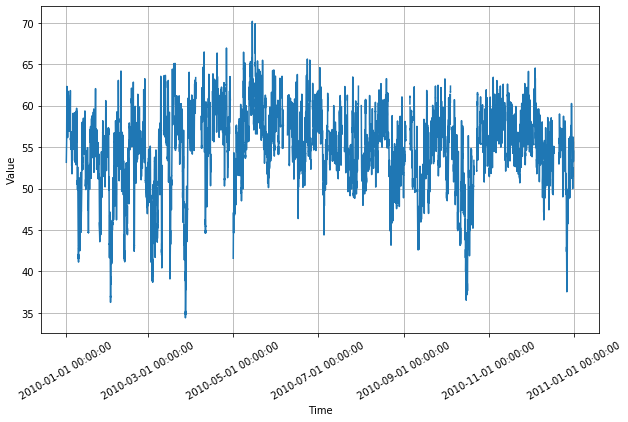

In [7]:
def plot_series(time, series, fmt="-", start=0, end=None):
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    plt.plot_date(time[start:end], series[start:end], fmt)
    plt.gca().xaxis.set_major_formatter(xfmt)
    plt.xticks(rotation=30)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

new_pwv[new_pwv==0]=np.nan
time_step = np.arange(len(new_pwv))
print(new_pwv.shape)
print(time_step.shape)
plt.figure(figsize=(10, 6))
plot_series(new_timestamp, new_pwv)
new_pwv[np.isnan(new_pwv)]=0

#Create dataset for training/testing & set some hyper-parameters

In [0]:
# Function to Create Window-Based Dataset
def create_dataset(data_list, timestamp_list, look_back=1):
    dataX, dataY, gap_idx, tsX, tsY = [], [], [], [], []
    gap_idx.append(0)
    for i in range(len(data_list)):
        dataset = data_list[i]
        timestamp = timestamp_list[i]
        for j in range(len(dataset)-look_back-1):
            a = dataset[j:(j+look_back+1)]
            b = timestamp[j:(j+look_back+1)]
            dataX.append(a)
            tsX.append(b)
            dataY.append(dataset[j + look_back + 1])
            tsY.append(timestamp[j + look_back + 1])
        gap_idx.append(len(dataX))
    return np.array(dataX), np.array(dataY), np.array(gap_idx), tsX, tsY

# Function to Add Gaps in the Sequence of Original Values
def add_gap(oriValues, gap_idx, gap):
    initIdx = 0
    gapValues = np.array([])
    for i in range(len(gap_idx)):
        gapValues = np.concatenate((gapValues, oriValues[initIdx:gap_idx[i]]))
        gapValues = np.concatenate((gapValues, np.zeros((gap[i]))))
        initIdx = gap_idx[i]
    return gapValues

series = new_pwv
time = time_step

look_back = 47
batch_size = 500
train_split = 0.8

dataX, dataY, gap_idx, tsX, tsY = create_dataset(pwv_cont_seq, timestamp_cont_seq, look_back)
split_time = int(train_split*len(dataY))

trainX = dataX[:split_time]
trainY = dataY[:split_time]
testX = dataX[split_time:]
testY = dataY[split_time:]

trainXts = tsX[:split_time]
trainYts = tsY[:split_time]
testXts = tsX[split_time:]
testYts = tsY[split_time:]

#Load previously created LSTM model

In [9]:
from tensorflow.keras.models import load_model

tf.keras.backend.clear_session()
#tf.set_random_seed(51)
#np.random.seed(51)
print("Before Reshaping")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

# Reshape Input to be [Samples, Time-Steps, Features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print("After Reshaping")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

# Load the trained LSTM Network
model = load_model('/content/drive/My Drive/pwv_lstm.h5')

Before Reshaping
(72008, 48)
(72008,)
(18003, 48)
(18003,)
After Reshaping
(72008, 48, 1)
(72008,)
(18003, 48, 1)
(18003,)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# Evaluate Model
print('Training Data Evaluation')
print(model.evaluate(x = trainX, y = trainY))
print('Test Data Evaluation')
print(model.evaluate(x = testX, y = testY))

Training Data Evaluation
72008/72008 [==============================] - 135s 2ms/sample - loss: 0.1949 - mean_squared_error: 0.3902
[0.1948851501601641, 0.3902226]
Test Data Evaluation
18003/18003 [==============================] - 33s 2ms/sample - loss: 0.1960 - mean_squared_error: 0.3937
[0.19603670041941737, 0.39368558]


In [11]:
forecast = model.predict(testX)
print(forecast.shape)
forecast = np.squeeze(forecast, axis=-1)
print(forecast.shape)

(18003, 1)
(18003,)


#Introduce Naive and Average methods of forecasting

In [10]:
def naiveForecast(x_data):
    # Expected Shape of x_data: (number of samples, number of readings per sample, 1)
    # Shape of forecast: (number of samples, )
    forecast = x_data[:,-1,0]
    return forecast

def avgForecast(x_data):
    # Expected Shape of x_data: (number of samples, number of readings per sample, 1)
    # Shape of forecast: (number of samples, )
    forecast = np.mean(x_data[:,:,0], axis=1)
    return forecast

naive_forecast = naiveForecast(testX)
print(naive_forecast.shape)
avg_forecast = avgForecast(testX)
print(naive_forecast.shape)

(18003,)
(18003,)


#Predicting in future according to the defined constant "stepsInFuture"

In [11]:
def predictFuture(dataset, modelFn, stepsInFuture, squeeze_dims=True, bias=0):
    for i in range(stepsInFuture):
        forecast = modelFn(dataset)
        if squeeze_dims:
            forecast = np.squeeze(forecast, axis=-1) + bias
        if i != stepsInFuture-1:
            forecast = np.expand_dims(forecast, axis=1)
            forecast = np.expand_dims(forecast, axis=1)
            dataset = np.append(dataset[:,1:,:], forecast, axis=1)
    return forecast

stepsInFuture = 3

futureForecast = predictFuture(testX, model.predict, stepsInFuture, bias=-0.62)
print(futureForecast.shape)

futureNaiveForecast = predictFuture(testX, naiveForecast, stepsInFuture, squeeze_dims=False)
print(futureNaiveForecast.shape)

futureAvgForecast = predictFuture(testX, avgForecast, stepsInFuture, squeeze_dims=False)
print(futureAvgForecast.shape)
'''
# Adding Gaps
gap_testY = add_gap(testY, testGapIdx, testGap)
gap_futureForecast = add_gap(futureForecast, testGapIdx, testGap)
gap_futureNaiveForecast = add_gap(futureNaiveForecast, testGapIdx, testGap)
gap_futureAvgForecast = add_gap(futureAvgForecast, testGapIdx, testGap)
'''

(18003,)
(18003,)
(18003,)


'\n# Adding Gaps\ngap_testY = add_gap(testY, testGapIdx, testGap)\ngap_futureForecast = add_gap(futureForecast, testGapIdx, testGap)\ngap_futureNaiveForecast = add_gap(futureNaiveForecast, testGapIdx, testGap)\ngap_futureAvgForecast = add_gap(futureAvgForecast, testGapIdx, testGap)\n'

Plotting the results:

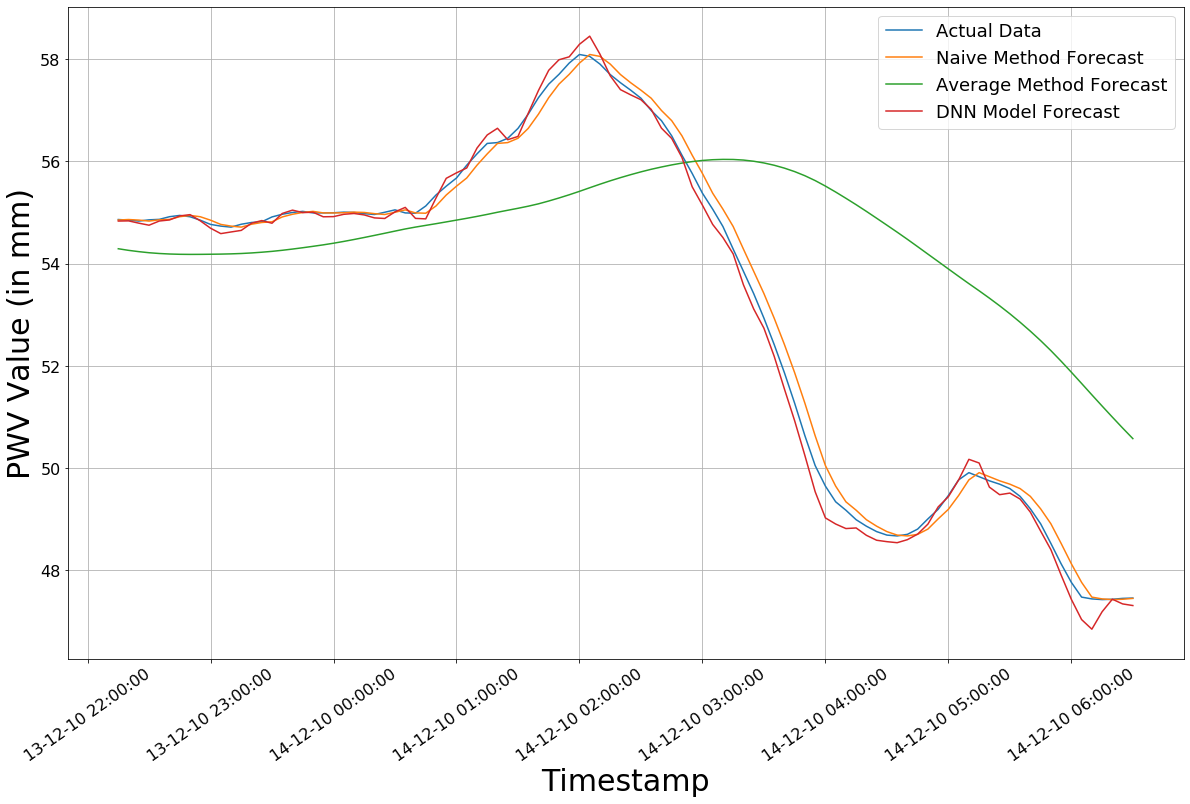

In [12]:
def plot_series_future(time, figWidth, figHeight, stepsInFuture, ori_seq, ori_ts, *args, **kwargs):
    plt.figure(figsize=(figWidth, figHeight))
    xfmt = md.DateFormatter('%d-%m-%y %H:%M:%S')
    pltTime = time
    ori_seq[ori_seq==0] = np.nan
    temp = ori_seq[time]
    plt.plot_date(ori_ts[pltTime[0]:pltTime[-1]+1], temp, '-')
    for arg in args:
        arg[arg==0] = np.nan
        temp = arg[time]
        plt.plot(ori_ts[pltTime[0]:pltTime[-1]+1], temp)
    plt.gca().xaxis.set_major_formatter(xfmt)
    plt.legend(tuple(kwargs.values()), fontsize=18)
    plt.xticks(fontsize=16, rotation=35)
    plt.yticks(fontsize=16)
    plt.xlabel("Timestamp", fontsize=30)
    plt.ylabel("PWV Value (in mm)", fontsize=30)
    plt.grid(True)

# Complete Plot
time = np.arange(13900,14000)
plot_series_future(time, 20, 12, stepsInFuture, testY, testYts, futureNaiveForecast, 
                   futureAvgForecast, futureForecast, l1 = "Actual Data", 
                   l2 = "Naive Method Forecast", l3 = "Average Method Forecast", 
                   l4 = "DNN Model Forecast")

Predicting using same past data for 'n' lead-steps in future

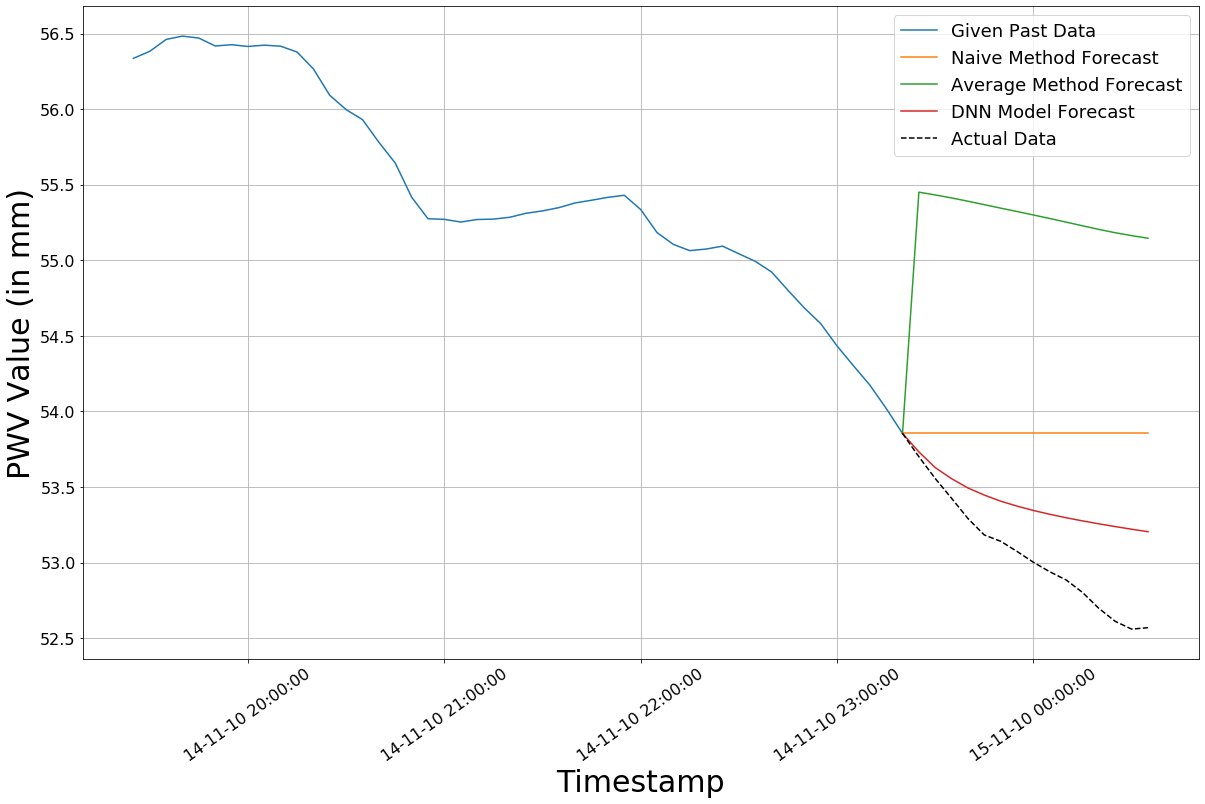

In [13]:
import datetime
bias = -0.62
leadSteps = 15
#evalIdx = testX.shape[0] - 1 - leadSteps # Taking data from towards the end
evalIdx = 6003

future_Dataset = np.expand_dims(testX[evalIdx], axis=0)
future_Naive_Dataset = np.expand_dims(testX[evalIdx], axis=0)
future_Avg_Dataset = np.expand_dims(testX[evalIdx], axis=0)
prediction = np.array([])
naivePrediction = np.array([])
avgPrediction = np.array([])
for futureSteps in range(1, leadSteps+1):
    # Forecasting using DNN Model
    future_Forecast = predictFuture(future_Dataset, model.predict, 1, bias=-0.62)
    prediction = np.append(prediction, future_Forecast)
    # Forecasting using Naive Method
    future_Naive_Forecast = predictFuture(future_Naive_Dataset, naiveForecast, 1, squeeze_dims=False)
    naivePrediction = np.append(naivePrediction, future_Naive_Forecast)
    # Forecasting using Average Method
    future_Avg_Forecast = predictFuture(future_Avg_Dataset, avgForecast, 1, squeeze_dims=False)
    avgPrediction = np.append(avgPrediction, future_Avg_Forecast)
    ##### Post-Processing Datasets for next steps
    # Post-Processing for DNN Model
    future_Forecast = np.expand_dims(future_Forecast, axis=1)
    future_Forecast = np.expand_dims(future_Forecast, axis=1)
    future_Dataset = np.append(future_Dataset[:,1:,:], future_Forecast, axis=1)
    # Post-Processing for Naive Method
    future_Naive_Forecast = np.expand_dims(future_Naive_Forecast, axis=1)
    future_Naive_Forecast = np.expand_dims(future_Naive_Forecast, axis=1)
    future_Naive_Dataset = np.append(future_Naive_Dataset[:,1:,:], future_Naive_Forecast, axis=1)
    # Post-Processing for Average Method
    future_Avg_Forecast = np.expand_dims(future_Avg_Forecast, axis=1)
    future_Avg_Forecast = np.expand_dims(future_Avg_Forecast, axis=1)
    future_Avg_Dataset = np.append(future_Avg_Dataset[:,1:,:], future_Avg_Forecast, axis=1)

future_Dataset = np.expand_dims(testX[evalIdx], axis=0)
oriData = np.squeeze(np.squeeze(future_Dataset, axis=0), axis=-1)
oriData2 = oriData[-1]
timeStamps = testXts[evalIdx]
timeStamps2 = [timeStamps[-1]]
for i in range(1, leadSteps+1):
    oriData2 = np.append(oriData2, np.squeeze(testX[evalIdx+i], axis=-1)[-1])
    timeStamps2.append(testXts[evalIdx+i][-1])

prediction = np.append(oriData[-1], prediction)
naivePrediction = np.append(oriData[-1], naivePrediction)
avgPrediction = np.append(oriData[-1], avgPrediction)

x_pltData = range(0, 48*5, 5)
xP_pltData = range((48-1)*5, (48+leadSteps)*5, 5)
plt.figure(figsize=(20, 12))
plt.plot_date(timeStamps, oriData, '-')
plt.plot_date(timeStamps2, naivePrediction, '-')
plt.plot_date(timeStamps2, avgPrediction, '-')
plt.plot_date(timeStamps2, prediction, '-')
plt.plot_date(timeStamps2, oriData2, '--k')
xfmt = md.DateFormatter('%d-%m-%y %H:%M:%S')
plt.gca().xaxis.set_major_formatter(xfmt)
plt.legend(("Given Past Data", "Naive Method Forecast", "Average Method Forecast", "DNN Model Forecast", "Actual Data"), fontsize=18)
plt.xticks(fontsize=16, rotation=35)
plt.yticks(fontsize=16)
plt.xlabel("Timestamp", fontsize=30)
plt.ylabel("PWV Value (in mm)", fontsize=30)
plt.grid(True)

Calculating RMSE values for the results:

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmseCalcFuture(ori_seq, test_seq, stepsInFuture):
    ori_seq[ori_seq==0] = np.nan
    ori_seq = np.append(ori_seq, np.zeros(stepsInFuture-1)+np.nan)
    test_seq[test_seq==0] = np.nan
    test_seq = np.append(np.zeros(stepsInFuture-1)+np.nan, test_seq)
    i = 0
    while i<len(ori_seq):
        if np.isnan(ori_seq[i]) or np.isnan(test_seq[i]):
            if i==0:
                ori_seq = ori_seq[1:]
                test_seq = test_seq[1:]
            elif i==len(ori_seq)-1:
                ori_seq = ori_seq[:-1]
                test_seq = test_seq[:-1]
            else:
                ori_seq = np.concatenate((ori_seq[:i], ori_seq[i+1:]))
                test_seq = np.concatenate((test_seq[:i], test_seq[i+1:]))
        else:
            i+=1
    #print("Shape of Reduced Original Sequence: ", ori_seq.shape)
    #print("Shape of Reduced Forecasted Sequence: ", test_seq.shape)
    return sqrt(mean_squared_error(ori_seq, test_seq))

print("Currently forecasting at", stepsInFuture, "steps in future...")
print("RMSE of Average Method Forecast = ", rmseCalcFuture(testY, futureAvgForecast, stepsInFuture))
print("RMSE of Naive Method Forecast = ", rmseCalcFuture(testY, futureNaiveForecast, stepsInFuture))
print("RMSE of DNN Model Forecast = ", rmseCalcFuture(testY, futureForecast, stepsInFuture))

Currently forecasting at 3 steps in future...
RMSE of Average Method Forecast =  1.4853869388863248
RMSE of Naive Method Forecast =  0.37045208477751174
RMSE of DNN Model Forecast =  0.3005417192546483


#Generating Tabular Results of RMSE Values for Different Steps in Future

In [15]:
print("RMSE Values for different steps in future:\n")
print("Steps In Future \t\t Naive Method \t\t\t Average Method \t\t DNN Model")
naiveRMSE = np.nan
avgRMSE = np.nan
dnnRMSE = np.nan

bias = -0.62

futureDataset = testX
futureNaiveDataset = testX
futureAvgDataset = testX
for stepsInFuture in range(1, 13):
    futureForecast = model.predict(futureDataset) + bias
    futureForecast = np.squeeze(futureForecast, axis=-1)
    futureNaiveForecast = naiveForecast(futureNaiveDataset)
    futureAvgForecast = avgForecast(futureAvgDataset)
    # Calculating RMSE
    rmsNaive = rmseCalcFuture(testY, futureNaiveForecast, stepsInFuture)
    rmsAvg = rmseCalcFuture(testY, futureAvgForecast, stepsInFuture)
    rmsDNN = rmseCalcFuture(testY, futureForecast, stepsInFuture)
    print(stepsInFuture, "\t\t\t\t", rmsNaive, "\t\t", rmsAvg, "\t\t", rmsDNN)
    # Storing RMSE Values
    naiveRMSE = np.append(naiveRMSE, rmsNaive)
    avgRMSE = np.append(avgRMSE, rmsAvg)
    dnnRMSE = np.append(dnnRMSE, rmsDNN)
    # Post-Processing Datasets for next steps
    futureForecast = np.expand_dims(futureForecast, axis=1)
    futureForecast = np.expand_dims(futureForecast, axis=1)
    futureDataset = np.append(futureDataset[:,1:,:], futureForecast, axis=1)
    futureNaiveForecast = np.expand_dims(futureNaiveForecast, axis=1)
    futureNaiveForecast = np.expand_dims(futureNaiveForecast, axis=1)
    futureNaiveDataset = np.append(futureNaiveDataset[:,1:,:], futureNaiveForecast, axis=1)
    futureAvgForecast = np.expand_dims(futureAvgForecast, axis=1)
    futureAvgForecast = np.expand_dims(futureAvgForecast, axis=1)
    futureAvgDataset = np.append(futureAvgDataset[:,1:,:], futureAvgForecast, axis=1)

RMSE Values for different steps in future:

Steps In Future 		 Naive Method 			 Average Method 		 DNN Model
1 				 0.1330400053951192 		 1.4212532989551414 		 0.09778781263284875
2 				 0.2580939059869864 		 1.4532072424908777 		 0.19664032286992994
3 				 0.37045208477751174 		 1.4853869388863248 		 0.3005417192546483
4 				 0.47427407477020617 		 1.5175847861327108 		 0.4050583981141527
5 				 0.5710315668930144 		 1.5496245422352841 		 0.5117648519587518
6 				 0.6616762426947442 		 1.5814277767304645 		 0.6174022702585852
7 				 0.7468624989859027 		 1.6129754608886553 		 0.7219360720181436
8 				 0.8272868537250125 		 1.6442544585422032 		 0.8248383442096842
9 				 0.9032980634912711 		 1.6751659467522857 		 0.925848024333582
10 				 0.9751491224753849 		 1.7056312860671812 		 1.0244225189831226
11 				 1.0432318231709146 		 1.7356260939820773 		 1.1208380239512823
12 				 1.1078651219679911 		 1.765204547489971 		 1.2148910990694006


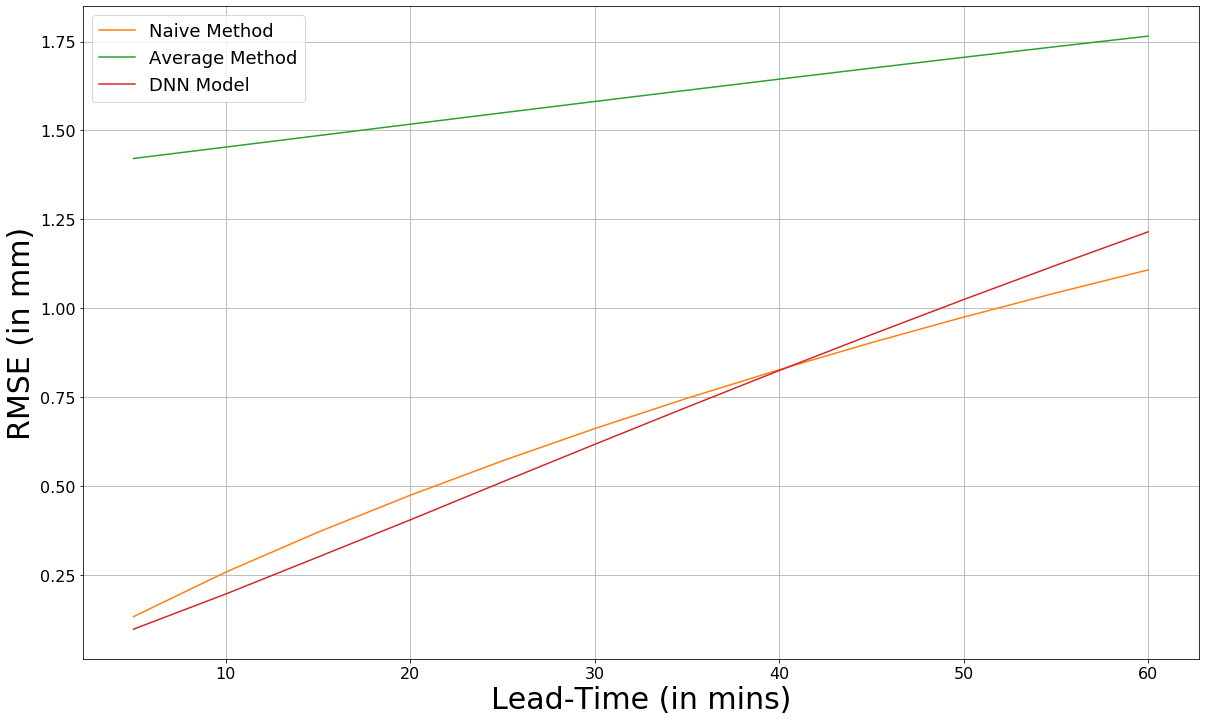

In [16]:
x_pltData = range(0,65,5)
plt.figure(figsize=(20, 12))
plt.plot(x_pltData, naiveRMSE, '#ff7f0e')
plt.plot(x_pltData, avgRMSE, '#2ca02c')
plt.plot(x_pltData, dnnRMSE, '#d62728')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Lead-Time (in mins)", fontsize=30)
plt.ylabel("RMSE (in mm)", fontsize=30)
plt.legend(("Naive Method", "Average Method", "DNN Model"), fontsize=18)
plt.grid(True)